In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
chm = np.zeros((100,100))

In [10]:
print(chm)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [139]:
def insert_tree(array, trunk_array, position, height, crown_radius, resolution=0.5, trunk_height=0.0, type='gaussian', randomness=0.8):
    '''
    Function

    Inputs:
    array (2d-numpy array):         Canopy Height Model Array (CHM)
    trunk_array (2d-numpy array):   Array of trunk heights
    position (tuple):               (row, col) coordinates for tree center.
    height (float):                 Total height of the tree.
    crown_radius (float):           Radius of the crown in real-world units.
    trunk_height (float):           Height of the trunk.
    type (str):                     Canopy shape type ('gaussian', 'cone', etc.).
    randomness (float):             Randomness/noise factor.
    resolution (float)              Real-world units per pixel (default = 1.0).

    Output:
    new_array (2d-numpy array):         Modified CHM array.
    new_trunk_array (2d-numpy array):   Modified Trunk height array
    '''
    new_array = np.copy(array)
    new_trunk_array = np.copy(trunk_array)

    crown_radius_px = crown_radius / resolution
    size = int(crown_radius_px * 2.5)

    # Calculate the distance from surrounding cells to the tree center
    x = np.arange(-size//2, size//2 +1)
    y = np.arange(-size//2, size//2 + 1)
    X, Y = np.meshgrid(x, y)
    distance = np.sqrt(X**2 + Y**2)

    # Create canopy shape
    if type == 'gaussian':
        canopy = (height - trunk_height) * np.exp(-distance**2 / (2 * (crown_radius_px / 2)**2)) + trunk_height
        print(canopy)
    elif type == 'cone':
        canopy = np.clip((height - trunk_height) * (1 - distance / crown_radius_px), 0, height - trunk_height) + trunk_height
    elif type == 'parabolic':
        canopy = (height - trunk_height) * (1 - (distance / crown_radius_px)**2)
        canopy = np.clip(canopy, 0, height - trunk_height) + trunk_height
    elif type == 'hemisphere':
        canopy = np.sqrt(np.clip(crown_radius_px**2 - distance**2, 0, None)) / crown_radius_px * (height - trunk_height) + trunk_height
    else:
        raise ValueError("Unsupported tree type.")

    mask = (distance <= crown_radius_px) & (canopy >= trunk_height)

    noise = np.random.normal(0, randomness, canopy.shape)
    canopy[mask] += noise[mask]

    canopy[~mask] = 0
    canopy = np.clip(canopy, 0, None)

    print(canopy)

    # Define insertion window
    row, col = position
    half_size = size // 2
    r_start = max(0, row - half_size)
    r_end = min(array.shape[0], row + half_size)
    c_start = max(0, col - half_size)
    c_end = min(array.shape[1], col + half_size)

    # Calculate actual insertion indices
    canopy_r_start = half_size - (row - r_start)
    canopy_r_end = canopy_r_start + (r_end - r_start)
    canopy_c_start = half_size - (col - c_start)
    canopy_c_end = canopy_c_start + (c_end - c_start)

    # Blend
    new_array[r_start:r_end, c_start:c_end] = np.maximum(
        array[r_start:r_end, c_start:c_end],
        canopy[canopy_r_start:canopy_r_end, canopy_c_start:canopy_c_end]
    )

    new_trunk_array[r_start:r_end, c_start:c_end] = np.minimum(
    trunk_array[r_start:r_end, c_start:c_end],
    trunk_height
    )

    return new_array, new_trunk_array


In [140]:
new_array, trunk_array = insert_tree(chm, chm, (50,50), 20, 10, type="gaussian")

[[0.03860908 0.04932779 0.06239515 ... 0.06239515 0.04932779 0.03860908]
 [0.04932779 0.06302223 0.07971737 ... 0.07971737 0.06302223 0.04932779]
 [0.06239515 0.07971737 0.10083521 ... 0.10083521 0.07971737 0.06239515]
 ...
 [0.06239515 0.07971737 0.10083521 ... 0.10083521 0.07971737 0.06239515]
 [0.04932779 0.06302223 0.07971737 ... 0.07971737 0.06302223 0.04932779]
 [0.03860908 0.04932779 0.06239515 ... 0.06239515 0.04932779 0.03860908]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


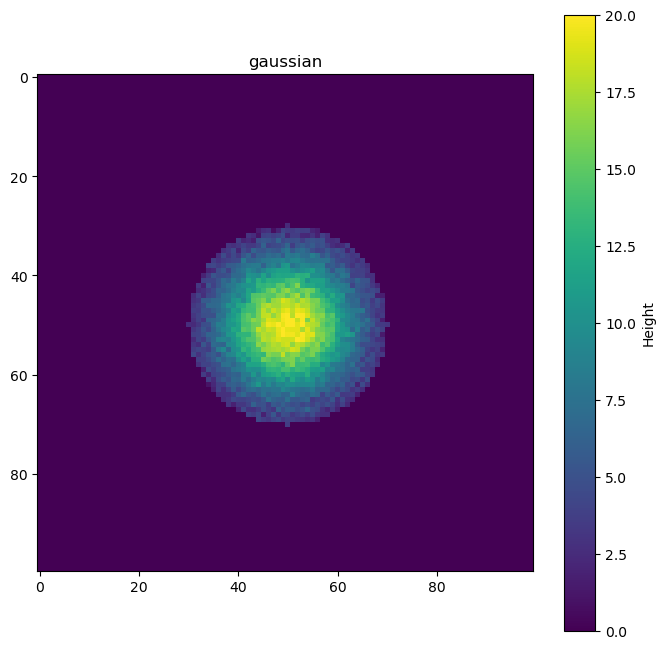

In [138]:
plt.figure(figsize=(8, 8))
plt.imshow(new_array, cmap='viridis', interpolation='none', vmin=0, vmax=20)
plt.colorbar(label="Height")
plt.title(f"gaussian")
plt.show()
